## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set plot style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Connect to PostgreSQL Database

In [2]:
# Database connection parameters
DB_PASSWORD = "tiger"
DB_CONFIG = {
    'dbname': 'ds_jobs',
    'user': 'postgres',
    'password': DB_PASSWORD,
    'host': 'localhost',
    'port': 5432
}

# Create SQLAlchemy engine for pandas integration
engine = create_engine(f'postgresql://{DB_CONFIG["user"]}:{DB_CONFIG["password"]}@{DB_CONFIG["host"]}:{DB_CONFIG["port"]}/{DB_CONFIG["dbname"]}')

# Create psycopg2 connection
conn = psycopg2.connect(**DB_CONFIG)
print("✓ Database connection successful!")

✓ Database connection successful!


## Dataset Overview

### First 5 rows of each table

In [3]:
# Load data from tables
jobpostings = pd.read_sql("SELECT * FROM jobpostings LIMIT 5;", engine)
skills_table = pd.read_sql("SELECT * FROM skills_table LIMIT 5;", engine)
skill_categories = pd.read_sql("SELECT * FROM skill_categories LIMIT 5;", engine)
job_skill_mapping = pd.read_sql("SELECT * FROM job_skill_mapping LIMIT 5;", engine)

print("\n=== Job Postings ===")
display(jobpostings)

print("\n=== Skills Table ===")
display(skills_table)

print("\n=== Skill Categories ===")
display(skill_categories)

print("\n=== Job-Skill Mapping ===")
display(job_skill_mapping)


=== Job Postings ===


,jobid,job_title_short,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,industry
0,1,Data Scientist,"San Francisco, CA",linkedin,Full-time,False,"California, United States",2024-01-15 10:30:00,False,True,United States,135000,Google,Technology
1,2,Data Engineer,"New York, NY",indeed,Full-time,False,"New York, United States",2024-01-20 14:20:00,True,True,United States,142000,Amazon,E-commerce/Technology
2,3,Machine Learning Engineer,"Seattle, WA",glassdoor,Full-time,True,"Washington, United States",2024-02-01 09:15:00,False,True,United States,158000,Microsoft,Technology
3,4,Data Analyst,"Austin, TX",linkedin,Full-time,False,"Texas, United States",2024-02-10 11:45:00,True,False,United States,85000,Meta,Social Media/Technology
4,5,Senior Data Scientist,"Boston, MA",indeed,Full-time,False,"Massachusetts, United States",2024-02-15 16:00:00,False,True,United States,165000,Apple,Technology/Consumer Electronics



=== Skills Table ===


,skill,skill_id
0,python,1
1,r,2
2,sql,3
3,tensorflow,4
4,scikit-learn,5



=== Skill Categories ===


,skill_id,skill_category
0,1,programming
1,2,programming
2,3,programming
3,4,libraries
4,5,libraries



=== Job-Skill Mapping ===


,jobid,skill_id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


### Column Types and Structure

In [4]:
jobpostings_full = pd.read_sql("SELECT * FROM jobpostings;", engine)
print(jobpostings_full.info())
print(f"\nDataset shapes:")
print(f"Job Postings: {jobpostings_full.shape}")
print(f"Skills: {pd.read_sql('SELECT COUNT(*) as count FROM skills_table', engine)['count'][0]} rows")
print(f"Skill Categories: {pd.read_sql('SELECT COUNT(*) as count FROM skill_categories', engine)['count'][0]} rows")
print(f"Job-Skill Mappings: {pd.read_sql('SELECT COUNT(*) as count FROM job_skill_mapping', engine)['count'][0]} rows")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   jobid                  20 non-null     int64         
 1   job_title_short        20 non-null     object        
 2   job_location           20 non-null     object        
 3   job_via                20 non-null     object        
 4   job_schedule_type      20 non-null     object        
 5   job_work_from_home     20 non-null     bool          
 6   search_location        20 non-null     object        
 7   job_posted_date        20 non-null     datetime64[ns]
 8   job_no_degree_mention  20 non-null     bool          
 9   job_health_insurance   20 non-null     bool          
 10  job_country            20 non-null     object        
 11  salary_year_avg        20 non-null     int64         
 12  company_name           20 non-null     object        
 13  industr

---
# 5 Questions Answered

Each question is answered by querying data from the PostgreSQL database with joins across multiple normalized tables.

## Q1. What are the main technologies?

### Top 20 Most In-Demand Skills

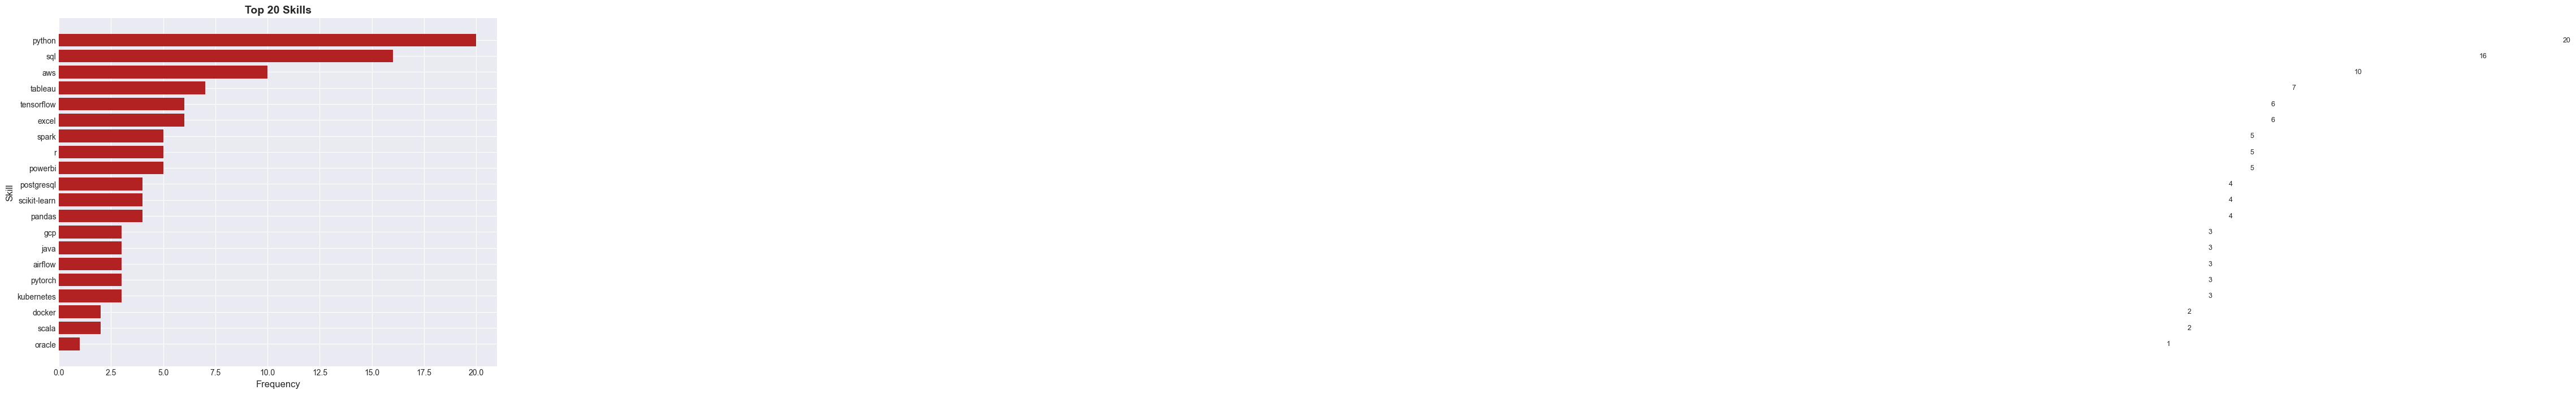

,skill,job_count
0,python,20
1,sql,16
2,aws,10
3,tableau,7
4,tensorflow,6
5,excel,6
6,spark,5
7,r,5
8,powerbi,5
9,postgresql,4


In [5]:
query = """
WITH SkillCount AS (
    SELECT st.skill,
    COUNT(jsm.jobid) AS job_count
    FROM job_skill_mapping jsm
    JOIN skills_table st ON jsm.skill_id = st.skill_id
    GROUP BY st.skill
)
SELECT skill, job_count
FROM SkillCount
ORDER BY job_count DESC
LIMIT 20;
"""

top20_skills = pd.read_sql(query, engine)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(top20_skills['skill'], top20_skills['job_count'], color='firebrick')
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Skill', fontsize=12)
ax.set_title('Top 20 Skills', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, (skill, count) in enumerate(zip(top20_skills['skill'], top20_skills['job_count'])):
    ax.text(count + 100, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../output/top20_skills.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

display(top20_skills)

### Top 10 Skills by Category

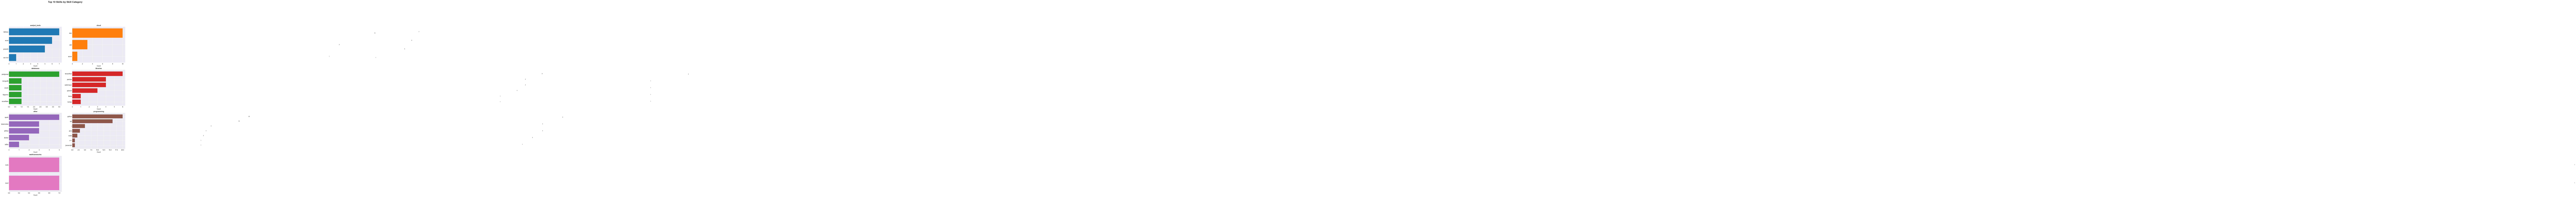

In [6]:
query = """
WITH SkillCount AS (
    SELECT sc.skill_category, st.skill,
    COUNT(jsm.jobid) AS job_count
    FROM job_skill_mapping jsm
    JOIN skills_table st ON jsm.skill_id = st.skill_id
    JOIN skill_categories sc ON st.skill_id = sc.skill_id
    GROUP BY sc.skill_category, st.skill
), 
RankedSkills AS (
    SELECT skill_category, skill, job_count,
    RANK() OVER (PARTITION BY skill_category ORDER BY job_count DESC) AS rank
    FROM SkillCount
)
SELECT skill_category, skill, job_count
FROM RankedSkills
WHERE rank <= 10
ORDER BY skill_category, rank;
"""

top10_by_cat = pd.read_sql(query, engine)

# Get unique categories
categories = top10_by_cat['skill_category'].unique()
n_categories = len(categories)

# Create subplots
fig, axes = plt.subplots(nrows=(n_categories + 1) // 2, ncols=2, figsize=(14, 5 * ((n_categories + 1) // 2)))
axes = axes.flatten()

colors = cm.tab10(range(n_categories))

for idx, category in enumerate(categories):
    cat_data = top10_by_cat[top10_by_cat['skill_category'] == category].sort_values('job_count', ascending=True)
    
    axes[idx].barh(cat_data['skill'], cat_data['job_count'], color=colors[idx])
    axes[idx].set_xlabel('Count', fontsize=10)
    axes[idx].set_title(f'{category}', fontsize=11, fontweight='bold')
    
    # Add value labels
    for i, (skill, count) in enumerate(zip(cat_data['skill'], cat_data['job_count'])):
        axes[idx].text(count + 50, i, str(count), va='center', fontsize=8)

# Hide empty subplots
for idx in range(n_categories, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Top 10 Skills by Skill Category', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('../output/top10_skill_cat.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

## Q2. What is the median salary for each job title?

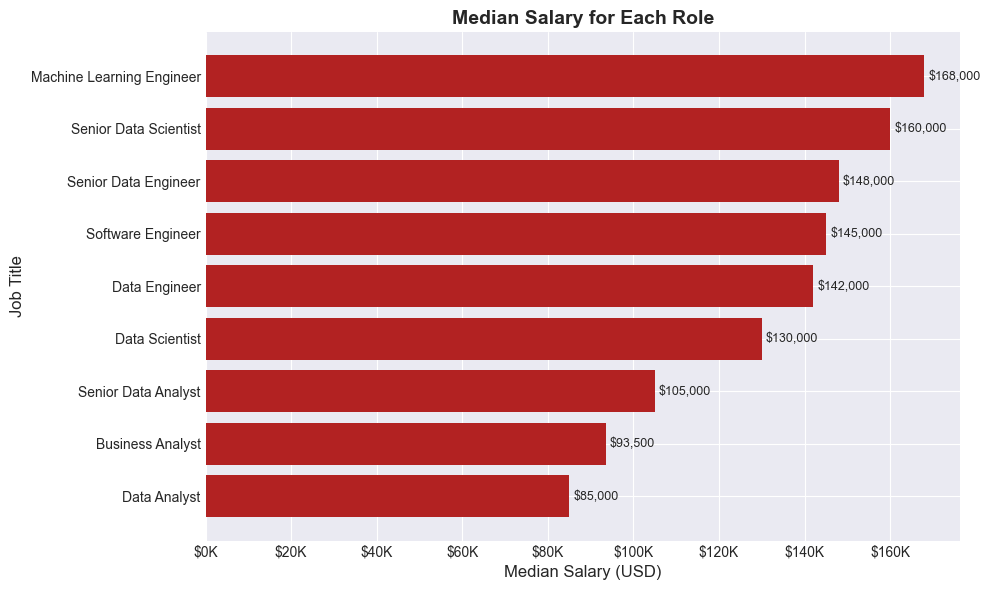

,job_title_short,med_salary
4,Machine Learning Engineer,168000.0
7,Senior Data Scientist,160000.0
6,Senior Data Engineer,148000.0
8,Software Engineer,145000.0
2,Data Engineer,142000.0
3,Data Scientist,130000.0
5,Senior Data Analyst,105000.0
0,Business Analyst,93500.0
1,Data Analyst,85000.0


In [7]:
query = "SELECT job_title_short, salary_year_avg FROM jobpostings;"
salary_data = pd.read_sql(query, engine)

# Calculate median salary by job title
median_salaries = salary_data.groupby('job_title_short')['salary_year_avg'].median().reset_index()
median_salaries.columns = ['job_title_short', 'med_salary']
median_salaries = median_salaries.sort_values('med_salary', ascending=False)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(median_salaries['job_title_short'], median_salaries['med_salary'], color='firebrick')
ax.set_xlabel('Median Salary (USD)', fontsize=12)
ax.set_ylabel('Job Title', fontsize=12)
ax.set_title('Median Salary for Each Role', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Format x-axis as currency
formatter = FuncFormatter(lambda x, pos: f'${x/1000:.0f}K')
ax.xaxis.set_major_formatter(formatter)

# Add value labels
for i, (title, salary) in enumerate(zip(median_salaries['job_title_short'], median_salaries['med_salary'])):
    ax.text(salary + 1000, i, f'${salary:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../output/med_salary_role.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

display(median_salaries)

### Top 20 Skills by Median Salary (by Category)

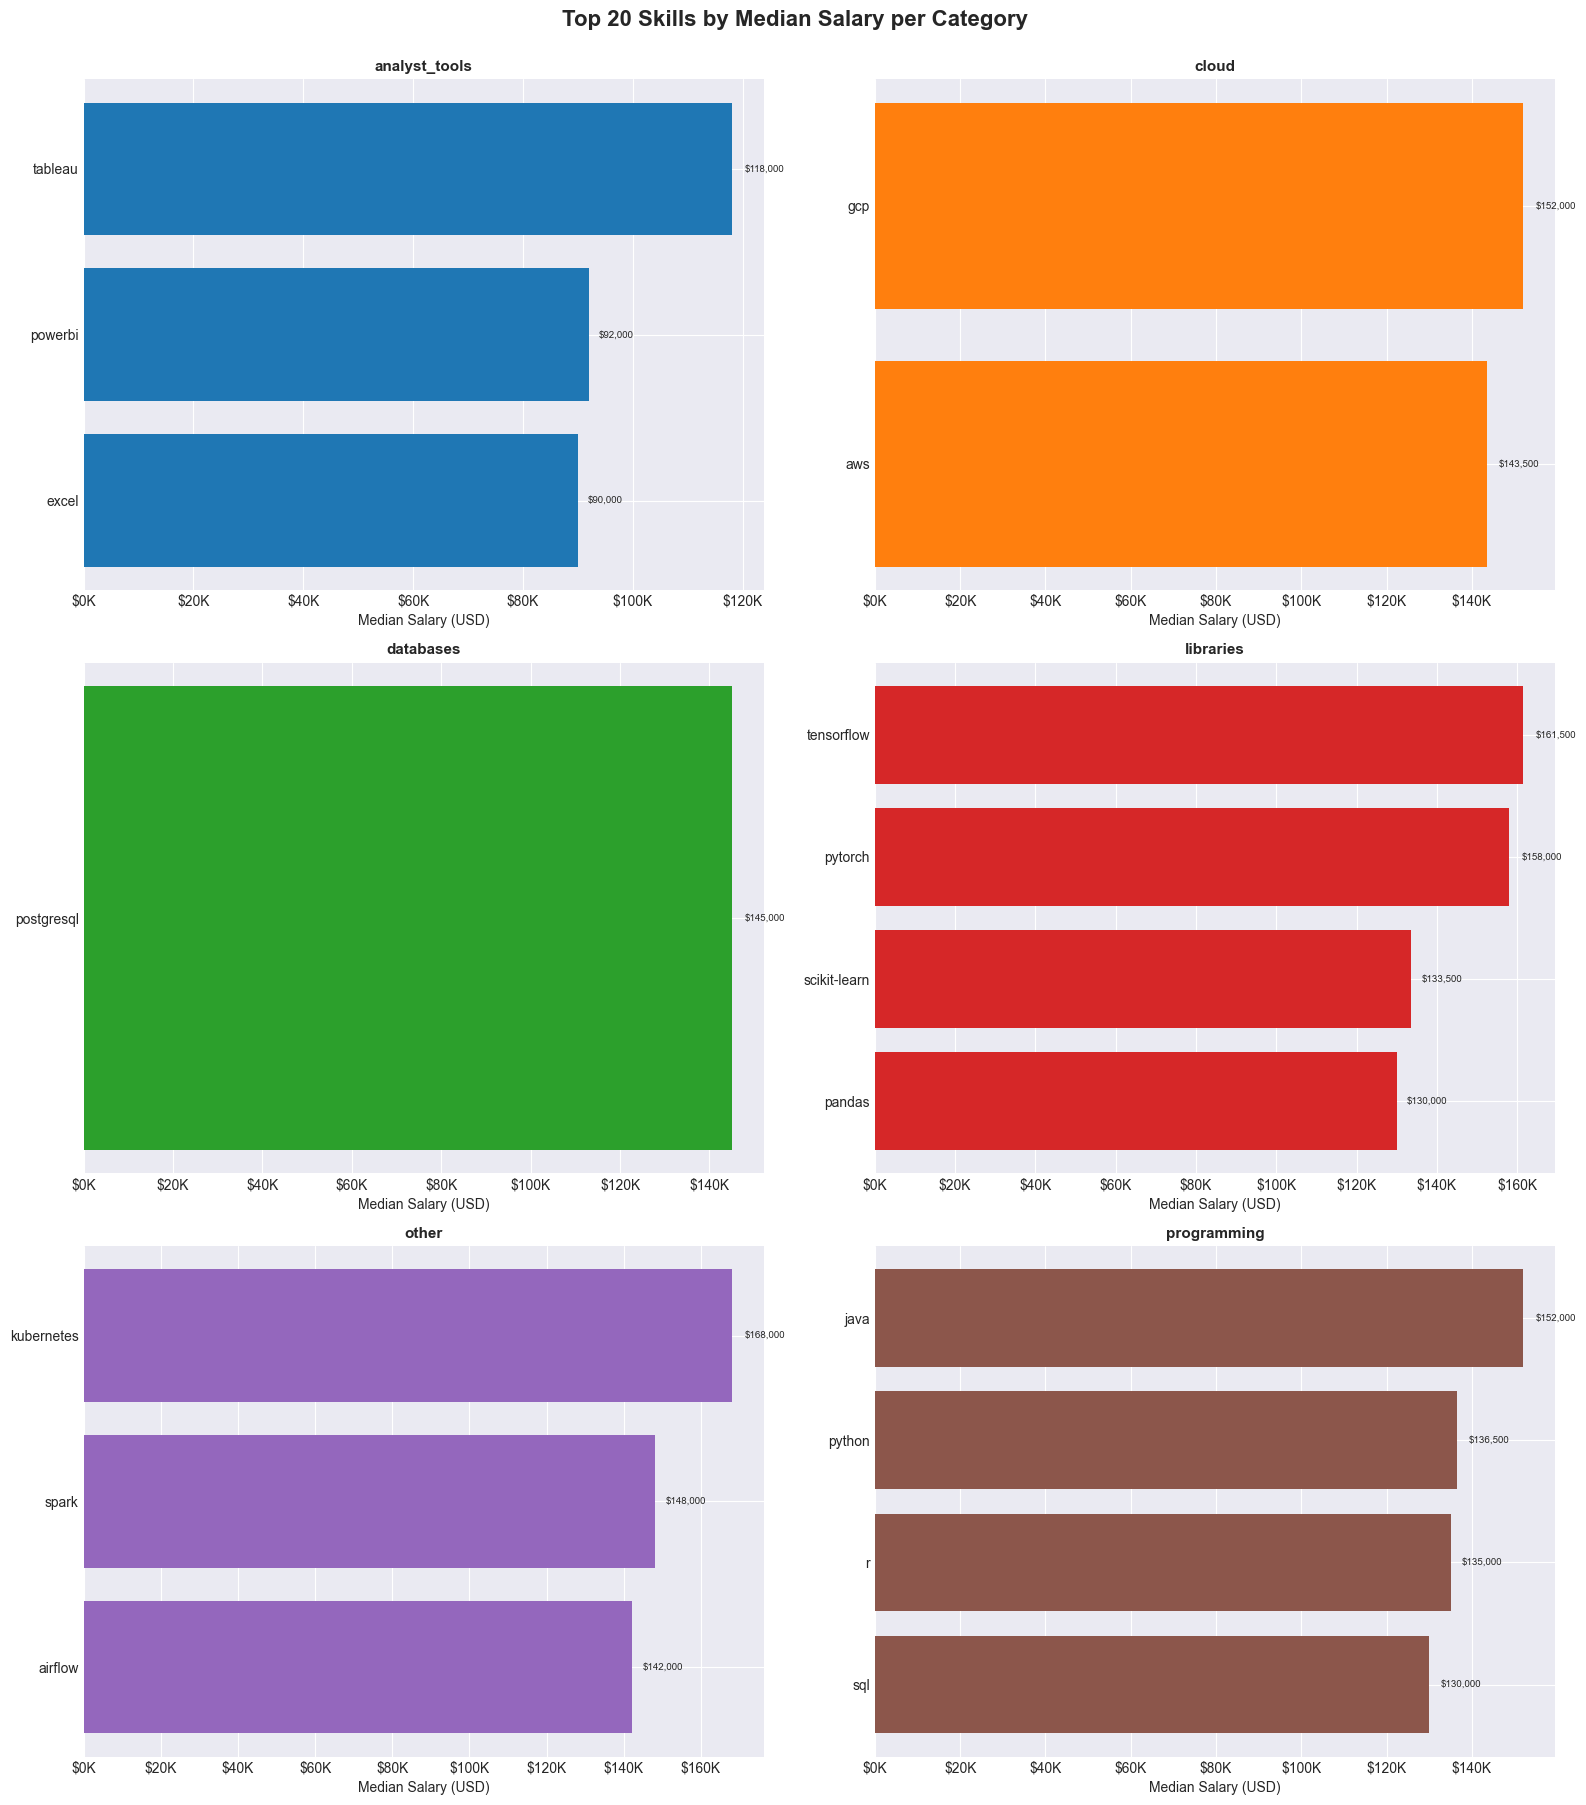

In [8]:
query = """
SELECT sc.skill_category, st.skill, jp.salary_year_avg
FROM job_skill_mapping jsm
JOIN skills_table st ON jsm.skill_id = st.skill_id
JOIN skill_categories sc ON st.skill_id = sc.skill_id
JOIN jobpostings jp ON jsm.jobid = jp.jobid;
"""

skill_salaries = pd.read_sql(query, engine)

# Calculate statistics
skill_stats = skill_salaries.groupby(['skill_category', 'skill']).agg(
    med_salary=('salary_year_avg', 'median'),
    n=('salary_year_avg', 'count'),
    max_salary=('salary_year_avg', 'max'),
    min_salary=('salary_year_avg', 'min')
).reset_index()

# Filter skills with at least 3 job postings (reduced for small dataset)
skill_stats = skill_stats[skill_stats['n'] >= 3]

# Get top 20 skills per category
top20_per_cat = skill_stats.groupby('skill_category').apply(
    lambda x: x.nlargest(20, 'med_salary')
).reset_index(drop=True)

# Create subplots only if we have categories
categories = top20_per_cat['skill_category'].unique()
n_categories = len(categories)

if n_categories > 0:
    # Ensure at least 1 row
    nrows = max(1, (n_categories + 1) // 2)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 6 * nrows))
    
    # Handle single plot case
    if n_categories == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    colors = cm.tab10(range(n_categories))
    
    for idx, category in enumerate(categories):
        cat_data = top20_per_cat[top20_per_cat['skill_category'] == category].sort_values('med_salary', ascending=True)
        
        axes[idx].barh(cat_data['skill'], cat_data['med_salary'], color=colors[idx])
        axes[idx].set_xlabel('Median Salary (USD)', fontsize=10)
        axes[idx].set_title(f'{category}', fontsize=11, fontweight='bold')
        formatter = FuncFormatter(lambda x, pos: f'${x/1000:.0f}K')
        axes[idx].xaxis.set_major_formatter(formatter)
        
        # Add value labels
        for i, (skill, salary) in enumerate(zip(cat_data['skill'], cat_data['med_salary'])):
            axes[idx].text(salary + (salary * 0.02), i, f'${salary:,.0f}', va='center', fontsize=7)
    
    # Hide empty subplots
    for idx in range(n_categories, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Top 20 Skills by Median Salary per Category', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.savefig('../output/top20skill_salary_cat.png', dpi=400, bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print("Not enough data to display skills by category (need at least 3 jobs per skill)")

## Q3. Which industry field is asking for these roles?

In [9]:
query = "SELECT industry FROM jobpostings WHERE industry IS NOT NULL;"
industry_data = pd.read_sql(query, engine)

# Count by industry
industry_counts = industry_data['industry'].value_counts().reset_index()
industry_counts.columns = ['industry', 'Count']

print(f"\nTotal industries: {len(industry_counts)}")
print(f"\nTop 20 Industries by Job Postings:")
display(industry_counts.head(20))

# Interactive table (if running in Jupyter)
display(industry_counts)


Total industries: 18

Top 20 Industries by Job Postings:


,industry,Count
0,Technology,2
1,Semiconductors/Technology,2
2,E-commerce/Technology,1
3,Social Media/Technology,1
4,Entertainment/Streaming,1
5,Technology/Consumer Electronics,1
6,Software/Cloud Computing,1
7,Consulting,1
8,Automotive/Technology,1
9,Technology/Consulting,1


,industry,Count
0,Technology,2
1,Semiconductors/Technology,2
2,E-commerce/Technology,1
3,Social Media/Technology,1
4,Entertainment/Streaming,1
5,Technology/Consumer Electronics,1
6,Software/Cloud Computing,1
7,Consulting,1
8,Automotive/Technology,1
9,Technology/Consulting,1


## Q4. What is the relation of location with respect to job postings and salary?

Analyzing Data Scientist salaries across US cities.

In [10]:
query = """
SELECT job_location, salary_year_avg 
FROM jobpostings
WHERE job_country = 'United States' AND job_title_short = 'Data Scientist';
"""

location_data = pd.read_sql(query, engine)

# Extract city (first part before comma)
location_data['city'] = location_data['job_location'].str.split(',').str[0]

# Calculate stats by city
city_stats = location_data.groupby('city').agg(
    n=('salary_year_avg', 'count'),
    med_salary=('salary_year_avg', 'median')
).reset_index()

# Filter cities with at least 10 postings
city_stats = city_stats[city_stats['n'] >= 10]

# Remove non-specific locations
exclude_cities = ['Toronto', 'United States', 'Anywhere', 'California']
city_stats = city_stats[~city_stats['city'].isin(exclude_cities)]

city_stats = city_stats.sort_values('med_salary', ascending=False)

print("\nTop 15 Cities by Median Salary for Data Scientists:")
display(city_stats.head(15))

# Note: For map visualization, you'd need geocoding (lat/lon coordinates)
# The original R script uses tidygeocoder. In Python, you can use geopy or saved coordinates
print("\n📍 For geographic visualization, geocoding coordinates would be needed.")
print("The original creates a US map with city markers sized by job count and colored by salary.")


Top 15 Cities by Median Salary for Data Scientists:


,city,n,med_salary



📍 For geographic visualization, geocoding coordinates would be needed.
The original creates a US map with city markers sized by job count and colored by salary.


## Q5. Does remote/work from home give lower pay than onsite?

Comparing remote vs onsite salaries for Full-time US jobs by state.

In [11]:
# Get onsite jobs
query_onsite = """
SELECT job_title_short, job_location, search_location, salary_year_avg 
FROM jobpostings
WHERE job_work_from_home = FALSE 
    AND job_country = 'United States' 
    AND job_schedule_type = 'Full-time';
"""

onsite = pd.read_sql(query_onsite, engine)

if len(onsite) == 0:
    print("No onsite jobs found in the dataset.")
else:
    # Extract state from location
    onsite['state'] = onsite['job_location'].str.split(',').str[-1].str.strip()
    onsite['state'] = onsite['state'].str.replace(r'\s*\(.*?\)', '', regex=True)
    
    # Normalize state abbreviations
    state_mapping = {
        'NY': 'New York',
        'GA': 'Georgia',
        'FL': 'Florida',
        'IL': 'Illinois',
        'CA': 'California',
        'TX': 'Texas'
    }
    onsite['state'] = onsite['state'].replace(state_mapping)
    
    print(f"Onsite jobs by state:\n{onsite['state'].value_counts()}")

# Get remote jobs
query_remote = """
SELECT job_title_short, job_location, search_location, salary_year_avg 
FROM jobpostings
WHERE job_work_from_home = TRUE 
    AND job_country = 'United States' 
    AND job_schedule_type = 'Full-time';
"""

remote = pd.read_sql(query_remote, engine)

if len(remote) == 0:
    print("\nNo remote jobs found in the dataset.")
else:
    # Extract state from search location
    remote['state'] = remote['search_location'].str.split(',').str[0]
    print(f"\nRemote jobs by state:\n{remote['state'].value_counts()}")

# Simple comparison if we have both types
if len(onsite) > 0 and len(remote) > 0:
    print("\n" + "="*50)
    print("REMOTE vs ONSITE SALARY COMPARISON")
    print("="*50)
    
    remote_avg = remote['salary_year_avg'].mean()
    onsite_avg = onsite['salary_year_avg'].mean()
    
    print(f"\nAverage Remote Salary: ${remote_avg:,.0f}")
    print(f"Average Onsite Salary: ${onsite_avg:,.0f}")
    print(f"Difference: ${remote_avg - onsite_avg:,.0f}")
    print(f"Percentage Difference: {((remote_avg - onsite_avg) / onsite_avg * 100):.1f}%")
    
    # Comparison by job title
    print("\nBy Job Title:")
    
    onsite_by_job = onsite.groupby('job_title_short')['salary_year_avg'].mean()
    remote_by_job = remote.groupby('job_title_short')['salary_year_avg'].mean()
    
    comparison = pd.DataFrame({
        'Onsite_Avg': onsite_by_job,
        'Remote_Avg': remote_by_job
    })
    comparison['Difference'] = comparison['Remote_Avg'] - comparison['Onsite_Avg']
    comparison['Pct_Diff'] = (comparison['Difference'] / comparison['Onsite_Avg'] * 100)
    
    display(comparison.style.format({
        'Onsite_Avg': '${:,.0f}',
        'Remote_Avg': '${:,.0f}',
        'Difference': '${:,.0f}',
        'Pct_Diff': '{:.1f}%'
    }).background_gradient(subset=['Pct_Diff'], cmap='RdYlGn'))
else:
    print("\nNot enough data for remote vs onsite comparison.")
    print("Sample dataset contains limited job types.")

print("\n✓ Analysis complete!")

Onsite jobs by state:
state
California    3
Texas         2
New York      1
MA            1
CO            1
AZ            1
Florida       1
MN            1
PA            1
Name: count, dtype: int64

Remote jobs by state:
state
United States    3
Washington       1
Illinois         1
Georgia          1
Oregon           1
California       1
Name: count, dtype: int64

REMOTE vs ONSITE SALARY COMPARISON

Average Remote Salary: $141,125
Average Onsite Salary: $122,500
Difference: $18,625
Percentage Difference: 15.2%

By Job Title:


,Onsite_Avg,Remote_Avg,Difference,Pct_Diff
job_title_short,,,,
Business Analyst,"$93,500",$nan,$nan,nan%
Data Analyst,"$83,667",$nan,$nan,nan%
Data Engineer,"$140,000","$152,000","$12,000",8.6%
Data Scientist,"$133,500","$123,000","$-10,500",-7.9%
Machine Learning Engineer,"$172,000","$163,000","$-9,000",-5.2%
Senior Data Analyst,$nan,"$105,000",$nan,nan%
Senior Data Engineer,"$148,000",$nan,$nan,nan%
Senior Data Scientist,"$165,000","$155,000","$-10,000",-6.1%
Software Engineer,$nan,"$145,000",$nan,nan%



✓ Analysis complete!


## Close Database Connection

In [12]:
conn.close()
print("Database connection closed.")

Database connection closed.
